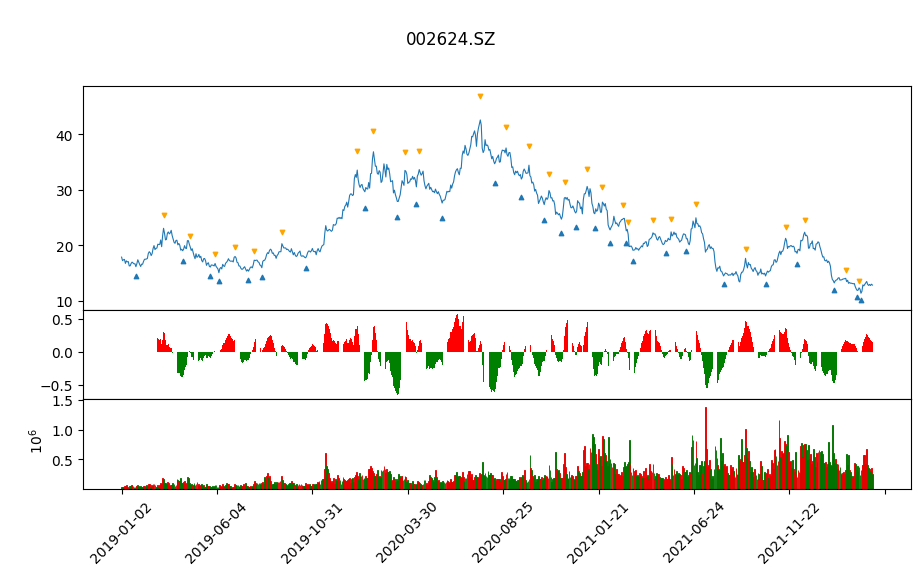

In [58]:
#https://github.com/matplotlib/mplfinance/blob/master/examples/addplot.ipynb
from xlib.astock import AStock
import talib as ta
import numpy as np 
import pandas as pd
import mplfinance as mpf
ts_code='002624.sz'
data=AStock.getStockDailyPriceByCode(ts_code,'tushare')
data=data[data['trade_date']>'20190101']
data=data[data['trade_date']<'20220401']
data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y%m%d')
data=data.set_index('trade_date')   



data["macd"], data["macd_signal"], data["macd_hist"] = ta.MACD(data['close'])
colors = ['r' if v >= 0 else 'g' for v in data["macd_hist"]]
macd_hist_plot = mpf.make_addplot(data["macd_hist"], type='bar', panel=1, color=colors) 

data['macd_hist_1']= data['macd_hist'].shift(1)
data['gold']=data.apply(lambda x: 1 if x['macd_hist_1']<=0 and x['macd_hist']>0   else 0, axis = 1)
data['death']=data.apply(lambda x: 1 if x['macd_hist_1']>=0 and x['macd_hist']<0   else 0, axis = 1)

data['high_signal']=np.nan
data['low_signal']=np.nan


max_value=0
min_value=9999
max_idx=0
min_idx=0


last_max=0
last_min=9999

data.sort_index()

for index, row in data.iterrows():
    
    if row['close']>max_value:
        max_value=row['close']
        max_idx=index

    elif row['close']<min_value:
        min_value=row['close']
        min_idx=index
    
    elif row['gold']==1 or row['death']==1:
        data.at[max_idx,'high_signal']=max_value*1.1
        data.at[min_idx,'low_signal']=min_value*0.9
        max_value=0
        min_value=9999      

        
#清理连续重复的点，在一个循环里也可以搞定，单开一个循环逻辑更清晰
flag="none"
high_value=0
high_index=0
low_value=9999
low_index=0
for index, row in data.iterrows():
    if  row['high_signal']>0 and row['low_signal']>0:
        data.at[index,'high_signal']=np.nan
        data.at[index,'low_signal']=np.nan
    
    if row['high_signal']>0 or row['low_signal']>0:
        if(flag=="none"):
            if not pd.isna(row['high_signal']):
                flag="high"
                high_value=row['close']
                high_index=index
            else:
                flag="low"
                low_value=row['close']
                low_index=index
        elif(flag=="high"):
            #如果上一个标记是high，且这个标记还是high
            if row['high_signal']>0:
                #如果现在的收盘价比上一个高点还高，那么清除掉上一个标记
                if(row['close']>high_value):
                    data.at[high_index,'high_signal']=np.nan
                    high_value=row['high_signal']
                    high_index=index
                else:
                    data.at[index,'high_signal']=np.nan
            else:
                flag="low"
                low_value=row['low_signal'] 
                low_index=index
        
        
        elif(flag=="low"):
            #如果上一个标记是low，且这个标记还是low
            if not pd.isna(row['low_signal']):
                #如果现在的收盘价比上一个低点还低，那么清除掉上一个标记
                if(row['close']<low_value):
                    data.at[low_index,'low_signal']=np.nan
                    low_value=row['low_signal']
                    low_index=index
                    
                else:
                    data.at[index,'low_signal']=np.nan
            else:
                flag="high"
                high_value=row['high_signal'] 
                high_index=index        

        else:
            pass

        
mycolor = mpf.make_marketcolors(up='red',down='green',inherit=True)
mystyle = mpf.make_mpf_style(y_on_right=False,marketcolors=mycolor)

high_signal_plot=mpf.make_addplot(data['high_signal'],type='scatter',markersize=10,marker='v',color='orange')
low_signal_plot=mpf.make_addplot(data['low_signal'],type='scatter',markersize=10,marker='^')


plots = [macd_hist_plot,high_signal_plot,low_signal_plot]

mpf.plot(data, 
         type='line',
         datetime_format='%Y-%m-%d',
         figratio=(20,10), 
         style=mystyle, 
         addplot=plots, 
         title=f"\n002624.SZ", 
         volume=True, 
         volume_panel=2,
         #vlines=dict(vlines=vlines,linewidths=0.5),
         ylabel='', 
         ylabel_lower=''
        )

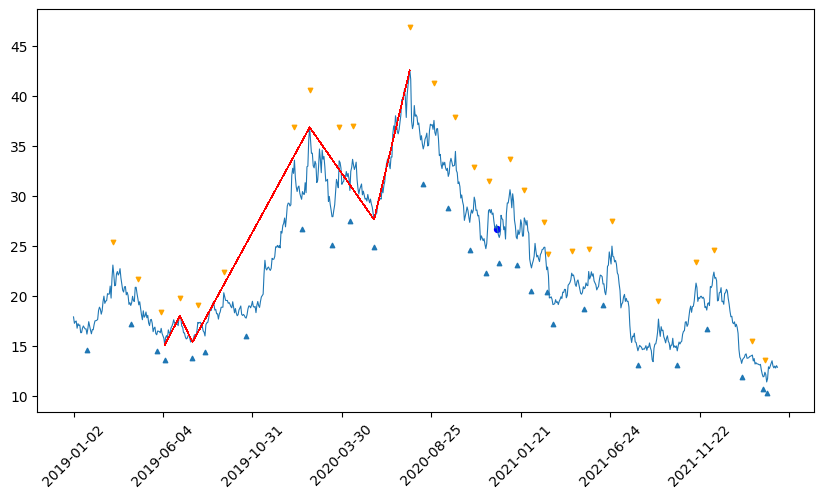

In [61]:
def wave(df,date,draw=True):
    date = pd.to_datetime(date, format='%Y%m%d')
    df2=df.loc[:date]
    df2=df2.dropna(subset=['close'])
    now=df2.iloc[-1]
    signal=df2.copy()[(df2.high_signal>0)|(df2.low_signal>0)]
    signal['signal']=signal.apply(lambda x:'high' if x['high_signal']>0 else 'low',axis=1)
    alines=[]
    now_close=now['close']

    #起点
    start=df2.loc[:df2['close'].idxmax()]['close'].idxmin()
    alines.append((start,df2.loc[start]['close']))

    #浪1
    for idx,row in signal.iterrows():
        if idx<start:
            pass
        elif(row['signal']=='high'):
            w1=idx
            break


    #浪5
    w5=df2['close'].idxmax() 
    
            
    
 
    #浪3
    signal3=signal.copy()
    signal3=signal3[start:w5]
    signal3=signal3.sort_values(by='close',ascending=False)
    w3=None
    for idx,row in signal3[1:].iterrows():
        #3不最短
        if(len(df2[start:idx]) >len(df2[idx:w5])):
            w3=idx
            break
    if(w3==None):
        print("5浪未成")

        
    #浪2
    signal2=signal.copy()
    signal2=signal2[w1:w3]
    signal2=signal2.sort_values(by='close',ascending=True)
    w2=None
    for idx,row in signal2.iterrows():
        #2不破1
        if(row['close']<df2.loc[w1]['close']):
            w2=idx
            break
    if(w2==None):
        print("5浪未成")        
     
    
    #浪4
    signal4=signal.copy()
    signal4=signal4[w3:w5]
    signal4=signal4.sort_values(by='close',ascending=True)
    w4=None
    for idx,row in signal4.iterrows():
        #4不进1
        if(row['close']>df2.loc[w1]['close']):
            w4=idx
            break
    if(w4==None):
        print("5浪未成")  
        
    alines.append((w1,df2.loc[w1]['close']))        
    alines.append((w2,df2.loc[w2]['close']))
    alines.append((w3,df2.loc[w3]['close']))
    alines.append((w4,df2.loc[w4]['close']))
    alines.append((w5,df2.loc[w5]['close']))

    data['mark']=np.nan
    data.at[df2.iloc[-1].name,'mark']=now_close
    
    mark_plot = mpf.make_addplot(data['mark'],type='scatter',color='b')

    plots = [high_signal_plot,low_signal_plot,mark_plot]
    
    mpf.plot(data, 
             type='line',
             datetime_format='%Y-%m-%d',
             figratio=(15,8), 
             style=mystyle, 
             addplot=plots, 
             volume=False,
             alines=dict(alines=alines,colors=['r'],linewidths=0.5),
             ylabel='', 
            #hlines=hlines,
             ylabel_lower=''
            )    


# wave(data,'20190823')

# wave(data,'20200823')
 
wave(data,'20201215')